In [ ]:
import numpy as np  # linear algebra
import pandas as pd  # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.  # 之前如此
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
# print(os.listdir("../input"))  # 已更改

# Any results you write to the current directory are saved as output.

In [ ]:
from google.colab import drive
drive.mount('/content/drive',  force_remount=True)

Mounted at /content/drive


In [ ]:
!python -V

Python 3.7.13


In [ ]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import sklearn
import sys
import tensorflow as tf
import time

from tensorflow import keras

print(tf.__version__)
print(sys.version_info)
for module in mpl, np, pd, sklearn, tf, keras:
    print(module.__name__, module.__version__)

2.8.0
sys.version_info(major=3, minor=7, micro=13, releaselevel='final', serial=0)
matplotlib 3.2.2
numpy 1.21.6
pandas 1.3.5
sklearn 1.0.2
tensorflow 2.8.0
keras.api._v2.keras 2.8.0


# 准备数据

In [ ]:
!pip install kaggle

In [ ]:
# 去kaggle那边拿数据，需要有key
import json
# /content/drive/MyDrive/kaggle_datasets
token = {"username":"wangpan0523","key":"f9d523149492466f3cbefd60421172d1"}
with open('/content/drive/MyDrive/kaggle_datasets/kaggle.json', 'w') as file:
  json.dump(token, file)

In [ ]:
!cat /content/drive/MyDrive/kaggle_datasets/kaggle.json

{"username": "wangpan0523", "key": "f9d523149492466f3cbefd60421172d1"}

In [ ]:
# Change the current working directory
%cd /content/drive/MyDrive/kaggle_datasets/

/content/drive/MyDrive/kaggle_datasets


In [ ]:
# !ls -l ~/drive/MyDrive/kaggle_datasets/.kaggle

ls: cannot access '/root/drive/MyDrive/.kaggle': No such file or directory


In [ ]:
# !mkdir -p ~/drive/MyDrive/kaggle_datasets/.kaggle
# !cp /content/drive/MyDrive/kaggle_datasets/kaggle.json ~/drive/MyDrive/colab_datasets/.kaggle/
# !chmod 600 ~/drive/MyDrive/kaggle_datasets/.kaggle/kaggle.json

In [ ]:
os.environ['KAGGLE_CONFIG_DIR'] = "/content/drive/MyDrive/kaggle_datasets/"

In [ ]:
# !kaggle config set -n path -v /content/drive/MyDrive/kaggle_datasets

In [ ]:
!which kaggle

/usr/local/bin/kaggle


In [ ]:
!ls sample_data

anscombe.json		      mnist_test.csv
california_housing_test.csv   mnist_train_small.csv
california_housing_train.csv  README.md


In [ ]:
# 核心就在这一步，如果这一步报错，就是前面的key没设置好，再设置一遍
!kaggle datasets download -d slothkong/10-monkey-species

 98% 537M/547M [00:04<00:00, 147MB/s]
100% 547M/547M [00:04<00:00, 130MB/s]


In [ ]:
!ls .

10-monkey-species.zip  kaggle.json


In [ ]:
!unzip -o -d . 10-monkey-species.zip

Archive:  10-monkey-species.zip
  inflating: ./monkey_labels.txt     
  inflating: ./training/training/n0/n0018.jpg  
  inflating: ./training/training/n0/n0019.jpg  
  inflating: ./training/training/n0/n0020.jpg  
  inflating: ./training/training/n0/n0021.jpg  
  inflating: ./training/training/n0/n0022.jpg  
  inflating: ./training/training/n0/n0023.jpg  
  inflating: ./training/training/n0/n0024.jpg  
  inflating: ./training/training/n0/n0025.jpg  
  inflating: ./training/training/n0/n0026.jpg  
  inflating: ./training/training/n0/n0027.jpg  
  inflating: ./training/training/n0/n0028.jpg  
  inflating: ./training/training/n0/n0029.jpg  
  inflating: ./training/training/n0/n0030.jpg  
  inflating: ./training/training/n0/n0031.jpg  
  inflating: ./training/training/n0/n0032.jpg  
  inflating: ./training/training/n0/n0033.jpg  
  inflating: ./training/training/n0/n0034.jpg  
  inflating: ./training/training/n0/n0035.jpg  
  inflating: ./training/training/n0/n0036.jpg  
  inflating: ./tra

In [ ]:
!ls /content/drive/MyDrive/

'Colab Notebooks'   kaggle_datasets


## 数据预处理

In [ ]:
# 数据路径规整、正确是前提
train_dir = "./training/training"
valid_dir = "./validation/validation"
label_file = "./monkey_labels.txt"
print(os.path.exists(train_dir))
print(os.path.exists(valid_dir))
print(os.path.exists(label_file))

print(os.listdir(train_dir))
print(os.listdir(valid_dir))

True
True
True
['n5', 'n8', 'n9', 'n3', 'n1', 'n0', 'n2', 'n4', 'n7', 'n6']
['n5', 'n8', 'n9', 'n3', 'n1', 'n0', 'n2', 'n4', 'n7', 'n6']


In [ ]:
!nvidia-smi

Fri May  6 03:44:31 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   47C    P8    29W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
labels = pd.read_csv(label_file, header=0)
print(labels)

   Label     Latin Name              Common Name                     \
0  n0         alouatta_palliata\t    mantled_howler                   
1  n1        erythrocebus_patas\t    patas_monkey                     
2  n2        cacajao_calvus\t        bald_uakari                      
3  n3        macaca_fuscata\t        japanese_macaque                 
4  n4       cebuella_pygmea\t        pygmy_marmoset                   
5  n5       cebus_capucinus\t        white_headed_capuchin            
6  n6       mico_argentatus\t        silvery_marmoset                 
7  n7      saimiri_sciureus\t        common_squirrel_monkey           
8  n8       aotus_nigriceps\t        black_headed_night_monkey        
9  n9       trachypithecus_johnii    nilgiri_langur                   

    Train Images    Validation Images  
0             131                  26  
1             139                  28  
2             137                  27  
3             152                  30  
4             131 

In [ ]:
height = 128
width = 128
channels = 3
batch_size = 64
num_classes = 10  # 类别数（10类猴子）

train_datagen = keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,  # 图片中的每个像素点都乘以1/255-归一化
    rotation_range=40,  # 把图形随机旋转一个角度，在0-40度之间
    width_shift_range=0.2,  # 位移，0-20%之间选择做偏移
    height_shift_range=0.2,  # 垂直方向位移，如果是0-1之间的数，就是比例，大于1就是像素
    shear_range=0.2,  # 剪切强度（逆时针剪切角，以度为单位）
    zoom_range=0.2,  # 缩放强度
    horizontal_flip=True,  # 水平随机翻转
    fill_mode='nearest',  # 图形放大后，有些地方需要填充
    # 可以是“常数”，“最近”，“反射”或“环绕”之一
    # 默认值为“最近”。输入边界之外的点将根据给定模式进行填充
)

# 读取图片
train_generator = train_datagen.flow_from_directory(train_dir,
                                                   # 生成图片多大
                                                   target_size=(height, width),
                                                   # 生成图片以多少张为一组
                                                   batch_size=batch_size,
                                                   seed=7,
                                                   shuffle=True,
                                                   # one-hot编码后的一种模式
                                                   class_mode="categorical")

# 对验证集必须做一个值的缩放，其他的不需要做
valid_datagen = keras.preprocessing.image.ImageDataGenerator(rescale = 1./255)
valid_generator = valid_datagen.flow_from_directory(valid_dir,
                                                    target_size = (height, width),
                                                    batch_size = batch_size,
                                                    seed = 7,
                                                    shuffle = False,
                                                    class_mode = "categorical")

train_num = train_generator.samples
valid_num = valid_generator.samples
print(train_num, valid_num)

Found 1098 images belonging to 10 classes.
Found 272 images belonging to 10 classes.
1098 272


In [ ]:
for i in range(2):
    x, y = train_generator.next()
    print(x.shape, y.shape)
    print(y)

(64, 128, 128, 3) (64, 10)
[[0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0.

## 搭建模型

In [ ]:
model = keras.models.Sequential([
    # 第一组卷积
    keras.layers.Conv2D(filters=32, kernel_size=3, padding='same',
                       activation='relu', input_shape=[width, height, channels]),
    keras.layers.Conv2D(filters=32, kernel_size=3, padding='same',
                       activation='relu'),
    keras.layers.MaxPool2D(pool_size=2),
    
    # 第二组卷积
    keras.layers.Conv2D(filters=64, kernel_size=3, padding='same',
                        activation='relu'),
    keras.layers.Conv2D(filters=64, kernel_size=3, padding='same',
                        activation='relu'),
    keras.layers.MaxPool2D(pool_size=2),
    
    # 第三组再翻倍
    keras.layers.Conv2D(filters=128, kernel_size=3, padding='same',
                        activation='relu'),
    keras.layers.Conv2D(filters=128, kernel_size=3, padding='same',
                        activation='relu'),
    keras.layers.MaxPool2D(pool_size=2),
    
    # 展平后，和全连接层做连接
    keras.layers.Flatten(),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dense(num_classes, activation='softmax'),
])

model.compile(loss="categorical_crossentropy",
             optimizer="adam", metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 32)      896       
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 32)      9248      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 64, 32)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 64, 64, 64)        18496     
                                                                 
 conv2d_3 (Conv2D)           (None, 64, 64, 64)        36928     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 32, 32, 64)       0         
 2D)                                                    

In [ ]:
len(model.layers)

12

In [ ]:
epochs = 50
# 如果机器性能好，可以把epochs改为300
history = model.fit_generator(train_generator,
                              # 显式指定
                              steps_per_epoch = train_num // batch_size,
                              epochs = epochs,
                              # 验证集
                              validation_data = valid_generator,
                              validation_steps = valid_num // batch_size)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  if __name__ == '__main__':


Epoch 1/50
17/17 [==============================] - 47s 2s/step - loss: 2.2793 - accuracy: 0.1122 - val_loss: 2.1724 - val_accuracy: 0.2188
Epoch 2/50
17/17 [==============================] - 37s 2s/step - loss: 2.1081 - accuracy: 0.2553 - val_loss: 1.9398 - val_accuracy: 0.3125
Epoch 3/50
17/17 [==============================] - 37s 2s/step - loss: 1.8487 - accuracy: 0.3631 - val_loss: 1.7021 - val_accuracy: 0.4375
Epoch 4/50
17/17 [==============================] - 36s 2s/step - loss: 1.7043 - accuracy: 0.3994 - val_loss: 1.6127 - val_accuracy: 0.4141
Epoch 5/50
17/17 [==============================] - 36s 2s/step - loss: 1.6138 - accuracy: 0.4072 - val_loss: 1.8267 - val_accuracy: 0.3711
Epoch 6/50
17/17 [==============================] - 36s 2s/step - loss: 1.7144 - accuracy: 0.3743 - val_loss: 1.6090 - val_accuracy: 0.3984
Epoch 7/50
17/17 [==============================] - 36s 2s/step - loss: 1.5348 - accuracy: 0.4429 - val_loss: 1.4712 - val_accuracy: 0.4688
Epoch 8/50
17/17 [==

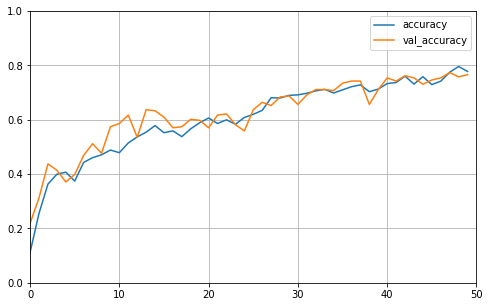

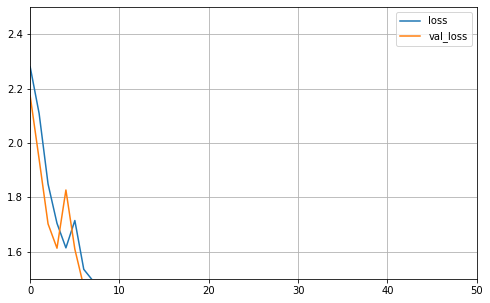

In [ ]:
def plot_learning_curves(history, label, epcohs, min_value, max_value):
    data = {}
    data[label] = history.history[label]
    data['val_'+label] = history.history['val_'+label]
    pd.DataFrame(data).plot(figsize=(8, 5))
    plt.grid(True)
    plt.axis([0, epochs, min_value, max_value])
    plt.show()
    
# 因为accuracy的值和loss值的范围很不一样，因此我们打印两条曲线
plot_learning_curves(history, 'accuracy', epochs, 0, 1)
plot_learning_curves(history, 'loss', epochs, 1.5, 2.5)